In [1]:
import pandas as pd
import numpy as np
import re
import string
from tensorflow.keras import layers, Sequential, Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Load Dataset ---
data = pd.read_csv("c:/MBAN- Schulich/MBAN- Sem 2/Data Science 2/Final Exam/Recipe Reviews and User Feedback Dataset.csv")
data['text'] = data['text'].fillna("no_comment")

Preprocessing:

In [3]:
# --- Feature Engineering ---
data['normalized_reputation'] = data['user_reputation'] / data['user_reputation'].max()
data['is_holiday_season'] = data['created_at'].apply(lambda x: 1 if pd.to_datetime(x, unit='s').month in [11, 12] else 0)

# --- Prepare Data ---
X = data['text'].values
y = pd.get_dummies(data['stars']).values  # One-hot encoding for star ratings

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Tokenizer Setup
vocabulary_size = 20000
max_len = 100
tokenizer = Tokenizer(num_words=vocabulary_size, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

def preprocess_text_data(X, tokenizer, max_len):
    seq = tokenizer.texts_to_sequences(X)
    seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    return seq

X_train_seq = preprocess_text_data(X_train, tokenizer, max_len)
X_val_seq = preprocess_text_data(X_val, tokenizer, max_len)
X_test_seq = preprocess_text_data(X_test, tokenizer, max_len)

# Numerical Features
numerical_features = ['normalized_reputation', 'is_holiday_season']
numerical_data = data[numerical_features].values
numerical_train = numerical_data[:len(X_train_seq)]
numerical_val = numerical_data[len(X_train_seq):len(X_train_seq) + len(X_val_seq)]
numerical_test = numerical_data[-len(X_test_seq):]

# --- Model 1: LSTM ---

In [4]:
lstm_model = Sequential([
    layers.Embedding(input_dim=vocabulary_size, output_dim=64, input_length=max_len),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')  # 6 categories (0-5 stars)
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train LSTM Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history_lstm = lstm_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10, batch_size=128,
    callbacks=[early_stopping]
)

# Evaluate LSTM Model
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_seq, y_test)

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step - accuracy: 0.7124 - loss: 1.1218 - val_accuracy: 0.7660 - val_loss: 0.8018
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 28s 323ms/step - accuracy: 0.7622 - loss: 0.7665 - val_accuracy: 0.7630 - val_loss: 0.7292
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 29s 337ms/step - accuracy: 0.7719 - loss: 0.6769 - val_accuracy: 0.7688 - val_loss: 0.7084
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 29s 340ms/step - accuracy: 0.8122 - loss: 0.5828 - val_accuracy: 0.7795 - val_loss: 0.7182
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 30s 350ms/step - accuracy: 0.8305 - loss: 0.5235 - val_accuracy: 0.7451 - val_loss: 0.7559
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 30s 349ms/step - accuracy: 0.8536 - loss: 0.4642 - val_accuracy: 0.7531 - val_loss: 0.7834
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7485 - loss: 0.8276


In [28]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,175,444 (15.93 MB)

 Trainable params: 1,391,814 (5.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,783,630 (10.62 MB)

In [27]:
print(f"LSTM Test Accuracy: {lstm_test_acc}")

LSTM Test Accuracy: 0.7585922479629517


# --- Model 2: Hybrid Model (LSTM + Numerical Features) ---

In [5]:
text_input = Input(shape=(max_len,))
numerical_input = Input(shape=(numerical_train.shape[1],))

# Text Embedding and LSTM-CNN Layers
embedding_layer = layers.Embedding(input_dim=vocabulary_size, output_dim=64)(text_input)
conv_layer = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = layers.MaxPooling1D(pool_size=2)(conv_layer)
lstm_layer = layers.Bidirectional(layers.LSTM(64))(pooling_layer)

# Combine Text and Numerical Features
concat_layer = layers.Concatenate()([lstm_layer, numerical_input])
dense_layer = layers.Dense(64, activation='relu')(concat_layer)
dropout_layer = layers.Dropout(0.5)(dense_layer)
output_layer = layers.Dense(6, activation='softmax')(dropout_layer)

# Compile Hybrid Model
enhanced_model = Model(inputs=[text_input, numerical_input], outputs=output_layer)
enhanced_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
def scheduler(epoch, lr):
    return lr if epoch < 5 else lr * 0.1

lr_schedule = LearningRateScheduler(scheduler)

# Train Hybrid Model
history_hybrid = enhanced_model.fit(
    [X_train_seq, numerical_train], y_train,
    validation_data=([X_val_seq, numerical_val], y_val),
    epochs=15, batch_size=128,
    callbacks=[early_stopping, lr_schedule]
)

# Evaluate Hybrid Model
hybrid_test_loss, hybrid_test_acc = enhanced_model.evaluate([X_test_seq, numerical_test], y_test)

Epoch 1/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - accuracy: 0.7132 - loss: 1.1536 - val_accuracy: 0.7660 - val_loss: 0.7822 - learning_rate: 0.0010
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 45s 431ms/step - accuracy: 0.7604 - loss: 0.7783 - val_accuracy: 0.7737 - val_loss: 0.7276 - learning_rate: 0.0010
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.7648 - loss: 0.6889 - val_accuracy: 0.7690 - val_loss: 0.7253 - learning_rate: 0.0010
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7859 - loss: 0.6315 - val_accuracy: 0.7608 - val_loss: 0.7558 - learning_rate: 0.0010
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8036 - loss: 0.5656 - val_accuracy: 0.7553 - val_loss: 0.7673 - learning_rate: 0.0010
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8130 - loss: 0.5222 - val_accuracy: 0.7446 - val_loss: 0.8161 - learning_rate: 1.0000e-04
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7480 - loss: 0.8478


In [29]:
enhanced_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 64)   │  1,280,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 96, 128)   │     41,088 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 48, 128)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │     98,816 │ max_pooling1d[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 130)       │          0 │ bidirectional_2[… │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,384 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        390 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,286,036 (16.35 MB)

 Trainable params: 1,428,678 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,857,358 (10.90 MB)

In [8]:
print(f"Hybrid Test Accuracy: {hybrid_test_acc}")

Hybrid Test Accuracy: 0.7530931830406189


# --- Model 3: CNN Model ---

In [6]:
cnn_model = Sequential([
    layers.Embedding(input_dim=vocabulary_size, output_dim=64, input_length=max_len),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')  # 6 categories (0-5 stars)
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN Model
history_cnn = cnn_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10, batch_size=128,
    callbacks=[early_stopping]
)

# Evaluate CNN Model
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_seq, y_test)
print(f"CNN Test Accuracy: {test_acc_cnn}")

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7098 - loss: 1.1466 - val_accuracy: 0.7660 - val_loss: 0.7884
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7549 - loss: 0.7809 - val_accuracy: 0.7660 - val_loss: 0.7550
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7548 - loss: 0.7153 - val_accuracy: 0.7666 - val_loss: 0.7512
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7607 - loss: 0.6691 - val_accuracy: 0.7657 - val_loss: 0.7877
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7941 - loss: 0.5714 - val_accuracy: 0.7635 - val_loss: 0.7916
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8103 - loss: 0.5082 - val_accuracy: 0.7377 - val_loss: 0.8542
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7407 - loss: 0.8601
CNN Test Accuracy: 0.7484190464019775


In [30]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 44, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,099,988 (15.64 MB)

 Trainable params: 1,366,662 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,733,326 (10.43 MB)

# --- Evaluation ---


Accuracy Comparison:
LSTM Test Accuracy: 0.7585922479629517
Hybrid Model Test Accuracy: 0.7530931830406189
CNN Test Accuracy: 0.7484190464019775
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.16      0.22       340
           1       0.50      0.07      0.12        46
           2       0.00      0.00      0.00        44
           3       0.26      0.30      0.28        98
           4       0.32      0.32      0.32       321
           5       0.84      0.92      0.88      2788

    accuracy                           0.76      3637
   macro avg       0.38      0.29      0.30      3637
weighted avg       0.72      0.76      0.73      3637



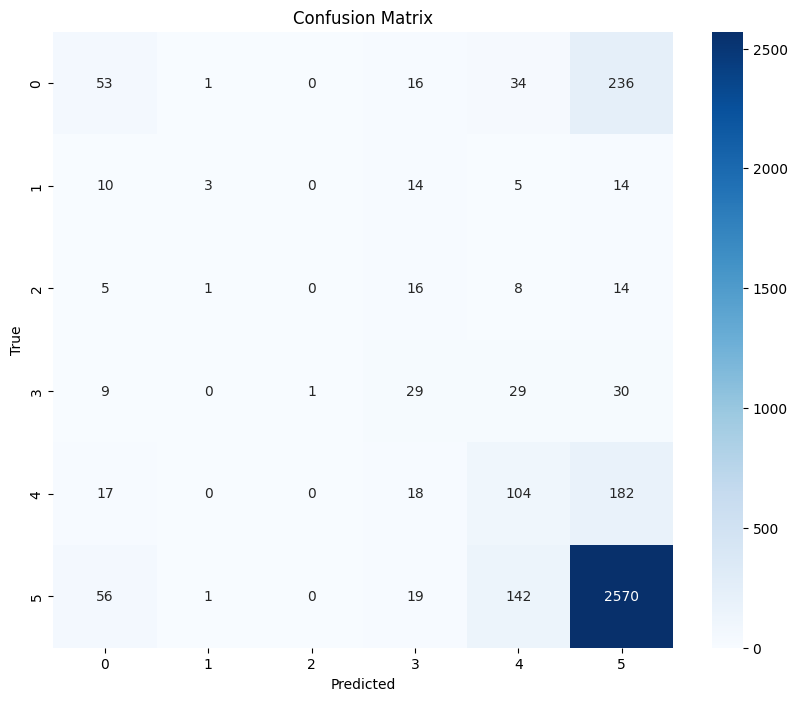

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Hybrid Model Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.11      0.16       340
           1       0.00      0.00      0.00        46
           2       0.00      0.00      0.00        44
           3       0.25      0.24      0.25        98
           4       0.25      0.29      0.27       321
           5       0.85      0.93      0.88      2788

    accuracy                           0.75      3637
   macro avg       0.28      0.26      0.26      3637
weighted avg       0.71      0.75      0.72      3637



c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

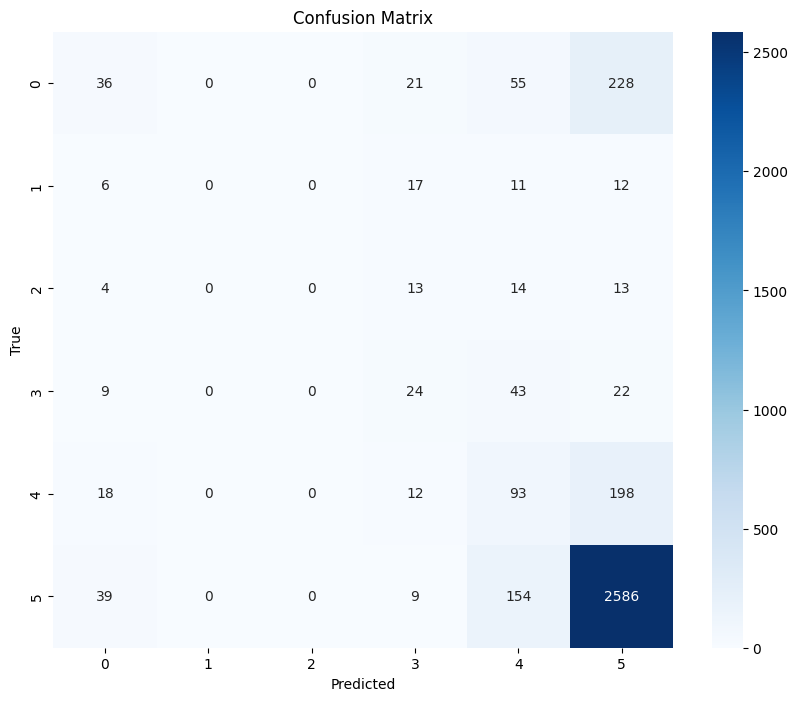

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.06      0.10       340
           1       0.00      0.00      0.00        46
           2       0.00      0.00      0.00        44
           3       0.27      0.29      0.28        98
           4       0.25      0.27      0.26       321
           5       0.84      0.93      0.88      2788

    accuracy                           0.75      3637
   macro avg       0.27      0.26      0.25      3637
weighted avg       0.69      0.75      0.71      3637



c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

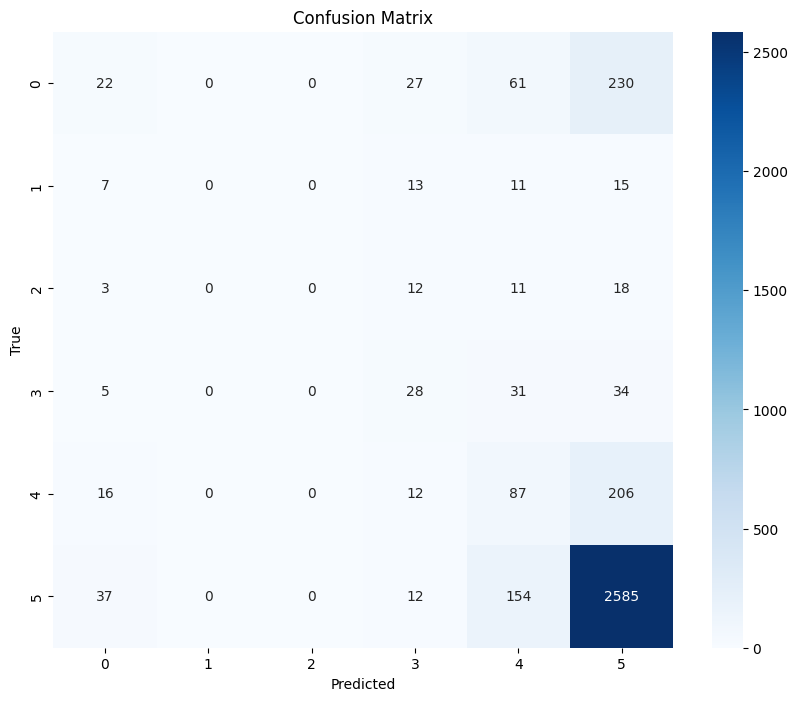

In [ ]:
print("\nAccuracy Comparison:")
print(f"LSTM Test Accuracy: {lstm_test_acc}")
print(f"Hybrid Model Test Accuracy: {hybrid_test_acc}")
print(f"CNN Test Accuracy: {test_acc_cnn}")

# Classification Report and Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

labels = [str(i) for i in range(6)]  # Star categories

# LSTM Confusion Matrix
y_pred_lstm = lstm_model.predict(X_test_seq).argmax(axis=1)
y_true = y_test.argmax(axis=1)
print("LSTM Classification Report:")
print(classification_report(y_true, y_pred_lstm, target_names=labels))
plot_confusion_matrix(y_true, y_pred_lstm, labels)

# Hybrid Model Confusion Matrix
y_pred_hybrid = enhanced_model.predict([X_test_seq, numerical_test]).argmax(axis=1)
print("Hybrid Model Classification Report:")
print(classification_report(y_true, y_pred_hybrid, target_names=labels))
plot_confusion_matrix(y_true, y_pred_hybrid, labels)

# CNN Model Confusion Matrix
y_pred_cnn = cnn_model.predict(X_test_seq).argmax(axis=1)
print("CNN Classification Report:")
print(classification_report(y_true, y_pred_cnn, target_names=labels))
plot_confusion_matrix(y_true, y_pred_cnn, labels)

# --- Visualizations ---

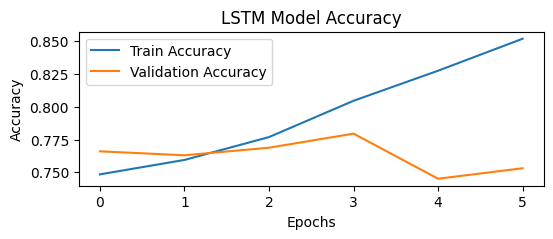

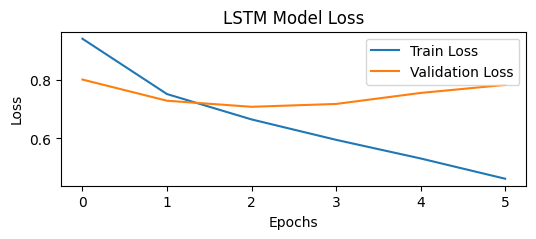

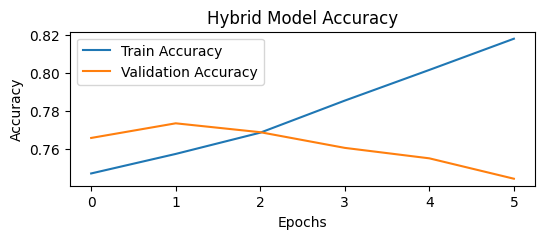

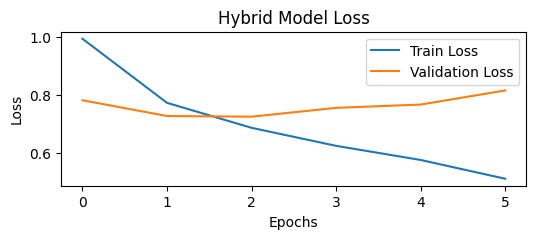

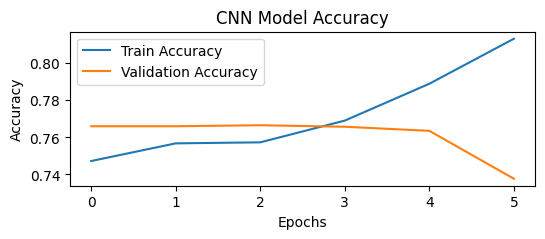

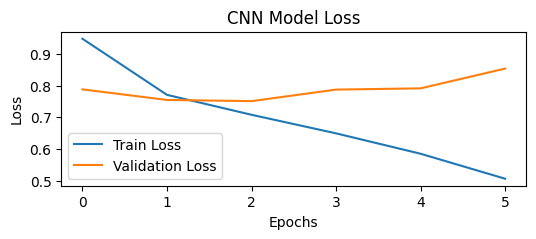

In [17]:
def plot_history(history, model_name):
    plt.figure(figsize=(6, 2))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 2))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_lstm, "LSTM Model")
plot_history(history_hybrid, "Hybrid Model")
plot_history(history_cnn, "CNN Model")

# --- Displaying Predictions ---

In [ ]:
def consolidate_predictions_unique(data, y_pred, model_name):
    """
    Consolidates predictions, ensuring one rating and sentiment per unique recipe.
    """
    # Ensure alignment between data and predictions
    if len(data) != len(y_pred):
        data = data.iloc[:len(y_pred)]
    
    # Combine data and predictions
    data = data.copy()
    data["Predicted Label"] = y_pred
    data["Sentiment"] = [categorize_sentiment(pred) for pred in y_pred]
    data["Predicted Star Rating"] = [f"{min(pred + 1, 5)} stars" for pred in y_pred]
    
    # Keep only unique recipes (e.g., by 'recipe_code') and take the first occurrence
    unique_predictions = data.groupby("recipe_code").first().reset_index()
    
    # Prepare final output
    predictions = unique_predictions[["recipe_code", "recipe_name", "Predicted Star Rating", "Sentiment"]]
    predictions.columns = ["Recipe Code", "Recipe Name", "Predicted Star Rating", "Sentiment"]
    
    # Convert to DataFrame and display
    print(f"\n{model_name} Predictions:\n")
    print(predictions.head())
    
    return predictions

# LSTM Model Predictions
predictions_lstm_df = consolidate_predictions_unique(data, y_pred_lstm, "LSTM Model")

# Hybrid Model Predictions
predictions_hybrid_df = consolidate_predictions_unique(data, y_pred_hybrid, "Hybrid Model")

# CNN Model Predictions
predictions_cnn_df = consolidate_predictions_unique(data, y_pred_cnn, "CNN Model")



LSTM Model Predictions:

   Recipe Code                Recipe Name Predicted Star Rating Sentiment
0         2832          Cheeseburger Soup               5 stars  Positive
1         3309     Best Ever Banana Bread               5 stars  Positive
2         6086                  Apple Pie               5 stars  Positive
3        12540  Flavorful Chicken Fajitas               5 stars  Positive
4        14299         Creamy White Chili               1 stars  Negative

Hybrid Model Predictions:

   Recipe Code                Recipe Name Predicted Star Rating Sentiment
0         2832          Cheeseburger Soup               5 stars  Positive
1         3309     Best Ever Banana Bread               5 stars  Positive
2         6086                  Apple Pie               5 stars  Positive
3        12540  Flavorful Chicken Fajitas               5 stars  Positive
4        14299         Creamy White Chili               1 stars  Negative

CNN Model Predictions:

   Recipe Code                Rec